# IMdB Sentiment Analysis

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.stem import SnowballStemmer , WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix


In [2]:
data = pd.read_csv('IMDB_Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df = data.sample(5000,random_state=100)

In [4]:
df

,review,sentiment
4253,This is a documentary about homeless women. It...,negative
30076,"Not well done at all, the whole movie was just...",negative
48047,It's strange what fate does to some people. Wh...,negative
1666,And that goes especially for lawyers & cops. P...,positive
30740,"First, an explanation: Despite my headline, I'...",positive
...,...,...
9701,I'm usually not inclined to write reviews abou...,negative
1304,This is one of the best movies. It is one of m...,positive
49735,STAR RATING: ***** Unmissable **** Very Good *...,positive
33756,This is one of the few movies released about a...,positive


## EDA

#####  Identifying missing values

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

##### overall view of the dataset

In [6]:
df.describe()

,review,sentiment
count,5000,5000
unique,4993,2
top,"in this movie, joe pesci slams dunks a basketb...",negative
freq,2,2503


In [7]:
df.sentiment.value_counts()

negative    2503
positive    2497
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

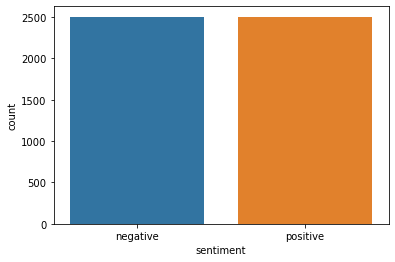

In [8]:
sns.countplot(df.sentiment)

The classes are balanced

### Data Preprocessing

**Process of Lemmatization is used for more clarity on the base words**

In [9]:
lemmatizer = WordNetLemmatizer()

# User defined function for tokenising and cleaning the text
def TokenizeandClean (review):
    '''
    The function returns the cleaned and lemmatized tokens of the text passed as argument.
    All the unncessary words are removed using the stopwords.
    arg : text to be cleaned.
    returns: cleaned text.
    '''
    review = re.sub('[^a-zA-Z]',' ',review)
    review = review.lower()
    review = word_tokenize(review)
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    return(review)

**The reviews have to be vectorized before feeding into the machine learning model**

In [10]:
# The review feature in the dataset is preprocessed

df.review = df.review.apply(TokenizeandClean)

In [11]:
# the dataaset is split into X(independent) and Y(dependent) variables

X = df['review']
Y = df['sentiment']

##### Splitting into train and test datas


- The dataset is split into training ang testing datasets
- We use the tf-idf vectorizer for vectorizing the tokenised text data
- The dependent variable is label encoded after the train test split


In [12]:
# the dataset is split into training and testing datasets

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state =42)

# Encoding the labels and preprocessing the texts are done after the train test split inorder to avoid data leakeage.

lab_encode = LabelEncoder()

y_train = lab_encode.fit_transform(y_train)
y_test = lab_encode.transform(y_test)

#Countvectorization of training and testing datasets
#cv= CountVectorizer()
#x_traincv = cv.fit_transform(x_train.values)
#x_testcv = cv.transform(x_test.values)


#TF IDF Vectorization of training and testing datasets

tf = TfidfVectorizer()

x_traintf = tf.fit_transform(x_train)
x_testtf = tf.transform(x_test)

### Model Selection Using Cross val score

In [13]:
# models are placed in a dictionary mapping to their objects

models = {'LogisticRegression':LogisticRegression(random_state=42),
          'RandomForest':RandomForestClassifier(random_state=42),
         'GradientBoost':GradientBoostingClassifier(random_state=42),
         'MultinomialNaiveBayes':MultinomialNB(),
         'XGBoost':XGBClassifier(random_state=42)}

# Function to select model using cross_val_score
def model_select(xtrain,ytrain):
    '''
    The function calculates the cross validated score of  a model using cross val score
    the mean of the score is calculated, appended and returned.
    =======================================================================================
    args:
    x_training : training x set
    y_training : training y set 
    '''
    acc_mean = []
    for model_name,model in models.items():
        acc_score = cross_val_score(model,xtrain,ytrain,scoring='accuracy',cv=10)
        print(str.center(model_name,40),'done....')
        acc_mean.append(round(acc_score.mean(),2))
    return (acc_mean)
                        
# Function to build model and get the score using the selected model
def model_build(xtrain,ytrain,xtest,ytest,finalmodel):
    '''
    The function trains the models with the training dataset, predicts the output sentiment, 
    calculates and returns the accuracy score, prints the confusion matrix and the 
    classification report.
    ========================================================================================
    args:
    x_training : training x set
    y_training : training y set
    x_testing  : testing x set
    y_true  : testing y set
    finalmodel : The finalised model selected 
    
    Returns an appended list of accuracies from all the models
    
    '''
    acc = []
    for model_name,model in models.items():
        if finalmodel == model_name:
            model.fit(xtrain,ytrain)
            print(str.center(model_name,40),'\n',str.center('='*25,50))
            ypred = model.predict(xtest)
            acc.append(round(accuracy_score(ytest,ypred),2))
            print(confusion_matrix(ytest,ypred))
            print(classification_report(ytest,ypred))
    return acc  

#accuracy_cv = model_build(x_traincv,y_train,x_testcv,y_test)

In [ ]:
# model selection with datasets that are vectorized using CountVectorizer

#acc_mean_cv = model_select(x_traincv,y_train)
#model_select_df = pd.DataFrame(acc_mean_cv,index = list(models.keys()),columns = ['cv_acc_mean'])


# model selection with datasets that are vectorized using TF IDF vectorizer

acc_mean_tf = model_select(x_traintf,y_train)
model_select_df = pd.DataFrame(acc_mean_tf,index = list(models.keys()),columns = ['tf_acc_mean'])

In [21]:
model_select_df = model_select_df.sort_values(by='tf_acc_mean')
model_select_df

,tf_acc_mean
GradientBoost,0.79
RandomForest,0.82
XGBoost,0.82
MultinomialNaiveBayes,0.85
LogisticRegression,0.86


<AxesSubplot:>

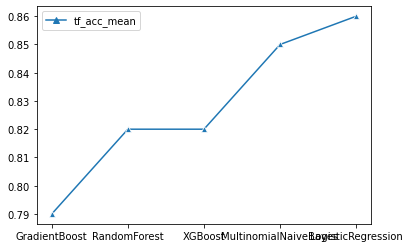

In [34]:

sns.lineplot(data = model_select_df,markers = '^')


Logistic Regression and Muntinomial Naive Bayes Classifier algorithms are giving above 85% accuracy


In [16]:
accuracy_tf = model_build(x_traintf,y_train,x_testtf,y_test,'LogisticRegression')

           LogisticRegression            
[[426  85]
 [ 57 432]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       511
           1       0.84      0.88      0.86       489

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



# Conclusion


**Logistic Regression is the best model coupled with TF-IDF Vectorizer**

In [20]:
#Testing our model with a real world review
msg = input('Enter the review :')

# tokenize and clean the review
msg = TokenizeandClean(msg)
# vectorize using tf idf
transformed_review = tf.transform([msg])
# predict the sentiment using logistic regression
ypredict = models['LogisticRegression'].predict(transformed_review)
# applying inverse transformimg on the predicted value to find the sentiment
lab_encode.inverse_transform(ypredict).item()

Enter the review :the movie shylock is undeniably boring and completely illogical and disappointed my expectations.


'negative'